# Library & Data Imports

In [41]:
import pandas as pd
from skfda.representation.basis import BSpline
from skfda.representation import FDataGrid
from skfda.preprocessing.dim_reduction import FPCA
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np
from skfda.representation.basis import BSpline
from skfda.representation.grid import FDataGrid
from tqdm import tqdm # Useful for tracking progress
from skfda.representation.basis import Basis

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2

In [42]:
# --- ASSUMED LOADED DATA ---
# Replace with your actual loading code:
df_train = pd.read_csv("../data/pirate_pain_train.csv")
df_labels = pd.read_csv("../data/pirate_pain_train_labels.csv")
df_test = pd.read_csv("../data/pirate_pain_test.csv")

# Data Preprocessing

In [43]:
# Assuming df_train is the long-format DataFrame
scalar_cols = ['sample_index', 'pain_survey_1', 'pain_survey_2', 'pain_survey_3', 'pain_survey_4', 
               'n_legs', 'n_hands', 'n_eyes']

# Extract the unique rows for each pirate (one row per sample_index)
df_scalars = df_train[scalar_cols].drop_duplicates(subset=['sample_index']).sort_values(by='sample_index')

In [44]:
# 1. Define the mapping for count-based strings
count_mapping = {
    'one': 1,
    'two': 2,
    'three': 3,
    'four': 4,
    # Add any other observed string values here
}

# 2. Apply mapping to the relevant columns
for col in ['n_legs', 'n_hands', 'n_eyes']:
    # Replace the string values with their corresponding integer. 
    # Use .fillna() to handle any unknown or missing strings after the mapping.
    df_scalars[col] = df_scalars[col].map(count_mapping).fillna(0).astype(int) 
    # NOTE: Filling with 0 assumes an unknown part count means 0, adjust as needed.

# 3. Handle Pain Surveys (Check if they need conversion)
# pain_survey_X columns appear to be integers (2, 0, 2, 1) in your sample, 
# but if they were strings (e.g., 'low', 'high'), they would also need mapping/OHE.

In [45]:
from sklearn.preprocessing import StandardScaler

# Drop the index column before scaling
X_scalars_raw = df_scalars.drop(columns=['sample_index']).values

# Apply Standard Scaling
scaler = StandardScaler()
X_scalars_scaled = scaler.fit_transform(X_scalars_raw)
X_scalars_scaled.shape  # Should be (num_samples, num_scalar_features)

(661, 7)

In [46]:
from skfda.representation.grid import FDataGrid

# --- ASSUMPTIONS BASED ON YOUR DATA STRUCTURE ---
# df_train has shape (160 * 661, 40)
# 'sample_index' identifies the 661 pirates.
# 'time' has 160 unique time steps.
functional_cols = [col for col in df_train.columns if col.startswith('joint_')]

# 1. Sort the DataFrame
# Ensure the data is sorted by pirate and then by time step. 
# This is crucial for the reshape operation to work correctly.
df_train_sorted = df_train.sort_values(by=['sample_index', 'time'])

# 2. Extract the functional domain (time vector)
t = df_train_sorted['time'].unique()
n_time_points = len(t) # Should be 160

# 3. Extract the functional values and reshape
X_functional = df_train_sorted[functional_cols].values
# X_functional shape is (105760, 31) where 105760 = 160 * 661

# Reshape to a 3D array: (n_pirates, n_time_points, n_functions)
n_pirates = df_train['sample_index'].nunique() # Should be 661
n_functions = len(functional_cols)           # Should be 31

X_functional_3D = X_functional.reshape(n_pirates, n_time_points, n_functions)

print(f"3D Functional Array X_functional_3D created with shape: {X_functional_3D.shape}")

3D Functional Array X_functional_3D created with shape: (661, 160, 31)


In [47]:
# Create the Functional Data Object
fd_train = FDataGrid(
    data_matrix=X_functional_3D,
    grid_points=t
)

# Corrected print statements
print(f"\n✅ Functional Data Object fd_train is now defined.")
print(f"   Samples (Pirates): {fd_train.n_samples}") # 661 (Number of functions/pirates)
print(f"   Features (Joints/Codomain): {fd_train.dim_codomain}") # 31 (Number of measurements per time point)


✅ Functional Data Object fd_train is now defined.
   Samples (Pirates): 661
   Features (Joints/Codomain): 31


In [48]:
# Assuming fd_train is defined (shape 661, 160, 31)
list_of_fd_grids = []

# Iterate through each of the 31 joint functions (codomain dimensions)
for i in range(fd_train.dim_codomain):
    # Select the i-th function (i.e., joint_i)
    fd_joint_i = fd_train.coordinates[i]
    list_of_fd_grids.append(fd_joint_i)
    
print(f"Split fd_train into {len(list_of_fd_grids)} separate FDataGrid objects.")

Split fd_train into 31 separate FDataGrid objects.


C:\Users\Leon\AppData\Local\Temp\ipykernel_5556\3319661513.py:9: DeprecationWarning: The BSpline class is deprecated. Use BSplineBasis instead.
  basis = BSpline(n_basis=n_basis)


Elbow plot saved to 'fpca_elbow_plot.png'


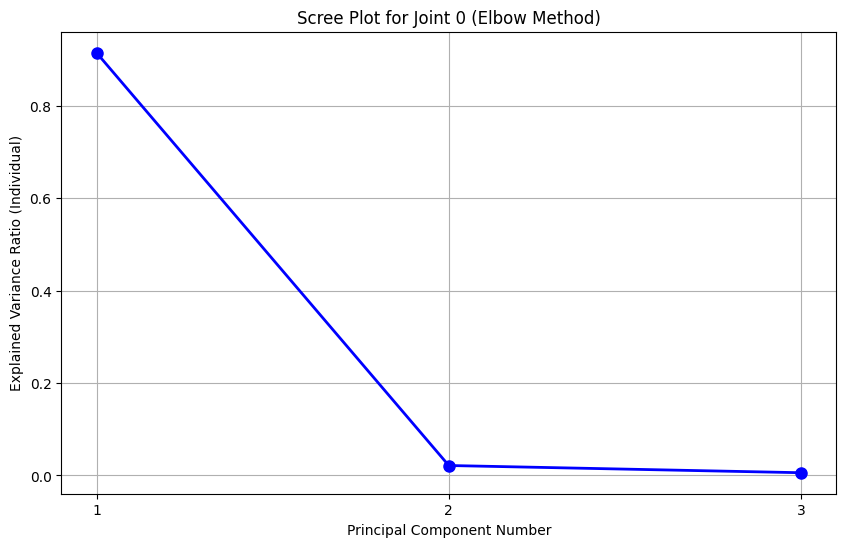

In [49]:
import matplotlib.pyplot as plt
import numpy as np
from skfda.preprocessing.dim_reduction import FPCA 
from skfda.representation.basis import BSpline

# --- 1. Setup Basis and Select Example Joint ---
# Use the same n_basis as your main pipeline
n_basis = 20
basis = BSpline(n_basis=n_basis)

# Select one joint to analyze (e.g., the first one)
# list_of_fd_grids comes from your notebook
fd_joint_example = list_of_fd_grids[0] 

# --- 2. Fit FPCA *without* n_components ---
# This is the key step: by not setting n_components, 
# it calculates variance for all components up to n_basis.
fpca_analyzer = FPCA(components_basis=basis)
fpca_analyzer.fit(fd_joint_example)

# --- 3. Get Explained Variance Ratios ---
# This holds the percentage of variance each component explains
explained_var = fpca_analyzer.explained_variance_ratio_
component_numbers = range(1, len(explained_var) + 1)

# --- 4. Plot the Scree Plot (Elbow Method) ---
plt.figure(figsize=(10, 6))
plt.plot(component_numbers, explained_var, 'bo-', linewidth=2, markersize=8)
plt.title('Scree Plot for Joint 0 (Elbow Method)')
plt.xlabel('Principal Component Number')
plt.ylabel('Explained Variance Ratio (Individual)')
plt.grid(True)
plt.xticks(component_numbers) # Ensure we have integer labels for each component
plt.savefig('fpca_elbow_plot.png')

print(f"Elbow plot saved to 'fpca_elbow_plot.png'")

In [50]:
from skfda.preprocessing.dim_reduction import FPCA 
from skfda.representation.basis import BSpline

# Configuration (e.g., let's use 3 components per joint for a total of 31 * 3 = 93 features)
n_components_per_joint = 3
n_basis = 20
basis = BSpline(n_basis=n_basis)

all_fpc_scores = []
fpca = FPCA(n_components=n_components_per_joint, components_basis=basis)

for i, fd_joint in enumerate(list_of_fd_grids):
    # Fit and transform the current joint's functional data
    fpca.fit(fd_joint)
    scores_i = fpca.transform(fd_joint)
    all_fpc_scores.append(scores_i)
    
    # Optional check: print(f"Joint {i} transformed to shape: {scores_i.shape}")

# Concatenate all scores horizontally (along the features axis)
X_fpc_scores_concatenated = np.hstack(all_fpc_scores)

print(f"Total FPCA Score Matrix shape: {X_fpc_scores_concatenated.shape}")
# Expected shape: (661, 31 * 3) = (661, 93)

C:\Users\Leon\AppData\Local\Temp\ipykernel_5556\257495552.py:7: DeprecationWarning: The BSpline class is deprecated. Use BSplineBasis instead.
  basis = BSpline(n_basis=n_basis)


Total FPCA Score Matrix shape: (661, 93)


In [51]:
# Assuming X_scalars_scaled is available (shape: 661, 7)
X_combined = np.hstack([X_fpc_scores_concatenated, X_scalars_scaled])

print(f"Final Combined Feature Matrix X_combined shape: {X_combined.shape}")
# Expected shape: (661, 93 FPCs + 7 Scalars) = (661, 100)

Final Combined Feature Matrix X_combined shape: (661, 100)


In [52]:
# Assuming df_labels was loaded earlier:
# df_labels = pd.read_csv("../data/pirate_pain_train_labels.csv")

# 1. Inspect df_labels to find the target column
# Assuming the labels file contains 'sample_index' and the target column is 'pirate_class' 
# (You may need to adjust 'target_column_name' based on your actual file).
TARGET_COLUMN_NAME = 'label' # Replace with the actual column name

# 2. Sort the labels by 'sample_index' to align with the features
# We must ensure the labels are in the same order as the pirates in X_functional_3D and X_scalars_scaled.
df_labels_sorted = df_labels.sort_values(by='sample_index')

# 3. Extract the target variable
y_train = df_labels_sorted[TARGET_COLUMN_NAME].values

print(f"✅ Target variable y_train defined with shape: {y_train.shape}")
print(f"Number of unique classes: {len(np.unique(y_train))}")

✅ Target variable y_train defined with shape: (661,)
Number of unique classes: 3


In [53]:
from sklearn.preprocessing import LabelEncoder
import numpy as np

# Assuming y_train is the array of string labels (e.g., ['no_pain', 'low_pain', 'no_pain', ...])

# 1. Initialize the LabelEncoder
label_encoder = LabelEncoder()

# 2. Fit the encoder to all unique labels and transform y_train
y_train_encoded = label_encoder.fit_transform(y_train)

# Update y_train to the new encoded version
y_train = y_train_encoded

# Print the mapping for verification
print("✅ String labels successfully mapped to integers.")
print(f"Original Classes: {label_encoder.classes_}")
print(f"Encoded Integers: {np.unique(y_train)}")

# Re-determine the number of classes using the encoded labels
num_classes = len(np.unique(y_train))

✅ String labels successfully mapped to integers.
Original Classes: ['high_pain' 'low_pain' 'no_pain']
Encoded Integers: [0 1 2]


In [54]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
import numpy as np

# Determine the number of classes and check if it's binary or multi-class
num_classes = len(np.unique(y_train))
is_binary = (num_classes == 2)

# Split the functional features and labels only
X_func_train, X_func_val, y_train_split, y_val = train_test_split(
    X_functional_3D,
    y_train,
    test_size=0.2, 
    random_state=42, 
    stratify=y_train 
)

# Prepare labels (One-Hot Encoding for multi-class)
if not is_binary:
    y_train_proc = to_categorical(y_train_split, num_classes=num_classes)
    y_val_proc = to_categorical(y_val, num_classes=num_classes)
else:
    y_train_proc = y_train_split
    y_val_proc = y_val

print("✅ Data split completed (Functional Data Only).")
print(f"Functional Training shape: {X_func_train.shape}")

✅ Data split completed (Functional Data Only).
Functional Training shape: (528, 160, 31)


In [55]:
from collections import Counter

# Assuming y_train is your final encoded integer array (0, 1, 2, ...)
class_counts = Counter(y_train)
total_samples = len(y_train)
num_classes = len(class_counts)

# Calculate weights dictionary
class_weights = {}
for cls, count in class_counts.items():
    class_weights[cls] = total_samples / (count * num_classes)
    
print(f"Calculated Class Weights: {class_weights}")

Calculated Class Weights: {np.int64(2): 0.43118069145466403, np.int64(1): 2.3439716312056738, np.int64(0): 3.9345238095238093}


# CONV1D Model

In [ ]:
import numpy as np
import random
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, GlobalMaxPooling1D, Dense, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from collections import Counter # Needed for class weight calculation

# --- 0. PRE-CALCULATIONS (For Class Weights) ---
# Assuming y_train is available and is the encoded integer array (0, 1, 2, ...)

# 1. Calculate class weights for imbalance correction
class_counts = Counter(y_train)
total_samples = len(y_train)
num_classes = len(class_counts)
class_weights = {}
for cls, count in class_counts.items():
    class_weights[cls] = total_samples / (count * num_classes)

# --- 1. Model Definition Function (Adapted for Conv1D) ---
def create_conv1d_model(conv_filters, kernel_size, dropout_rate, l2_penalty, input_shape, num_classes):
    """Creates a regularized Conv1D model with customizable hyperparameters."""
    
    model = Sequential()
    
    # Layer 1: Conv1D with L2 regularization
    model.add(Conv1D(
        filters=conv_filters,
        kernel_size=kernel_size,
        activation='relu',
        input_shape=input_shape, # Uses input_shape derived from X_functional_3D
        kernel_regularizer=l2(l2_penalty)
    ))
    model.add(Dropout(dropout_rate))
    
    # Global Pooling (Converts sequence output to fixed-length vector)
    model.add(GlobalMaxPooling1D())

    # Output Layer (Dense layer, uses L2 regularization)
    model.add(Dense(num_classes, activation='softmax', kernel_regularizer=l2(l2_penalty)))

    model.compile(
        optimizer=Adam(learning_rate=0.001), 
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

# --- 2. Setup Search Space (Adapted for Conv1D) ---
input_shape = X_functional_3D.shape[1:] 
num_classes = len(np.unique(y_train)) 

param_grid = {
    'conv_filters': [64, 96, 128],
    'kernel_size': [3, 5, 7, 9], # Try larger kernels
    'dropout_rate': [0.2, 0.3, 0.4, 0.5],
    'l2_penalty': [1e-4, 1e-5],
    'batch_size': [16, 32],
    'learning_rate': [1e-3, 5e-4, 1e-4] # <-- ADD THIS
}

N_TRIALS = 50 # Number of random hyperparameter combinations to test
N_SPLITS = 5 # 5-Fold Cross-Validation

# --- 3. Cross-Validation (CV) Random Search ---
best_avg_f1 = -1
best_params = {}
skf = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=42)

print(f"Starting Random Search CV (Conv1D) with {N_TRIALS} trials and {N_SPLITS} folds...")

for i in range(N_TRIALS):
    # Select random parameters for this trial
    params = {
        'conv_filters': random.choice(param_grid['conv_filters']),
        'kernel_size': random.choice(param_grid['kernel_size']),
        'dropout_rate': random.choice(param_grid['dropout_rate']),
        'l2_penalty': random.choice(param_grid['l2_penalty']),
        'batch_size': random.choice(param_grid['batch_size'])
    }
    
    fold_f1_scores = []
    
    # Define Callbacks for robust training within the fold
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=0)
    lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6, verbose=0)

    print(f"\n--- Trial {i+1}/{N_TRIALS}. Params: {params} ---")

    # --- 4. K-Fold Training and Evaluation ---
    for fold_n, (train_index, val_index) in enumerate(skf.split(X_functional_3D, y_train)):
        
        # Split Data and Prepare OHE labels for Keras
        X_fold_train = X_functional_3D[train_index]
        X_fold_val = X_functional_3D[val_index]
        y_fold_train_enc = to_categorical(y_train[train_index], num_classes=num_classes)
        
        # Prepare parameters for model creation (excluding batch_size)
        model_creation_params = {k: v for k, v in params.items() if k != 'batch_size'}
        
        # 1. Create Model (Using the new Conv1D function)
        model_trial = create_conv1d_model(
            input_shape=input_shape, num_classes=num_classes, **model_creation_params
        )
        
        # 2. Train Model (Applying class_weight for imbalance)
        model_trial.fit(
            X_fold_train, y_fold_train_enc,
            validation_data=(X_fold_val, to_categorical(y_train[val_index], num_classes=num_classes)),
            epochs=100, 
            batch_size=params['batch_size'], 
            callbacks=[early_stopping, lr_scheduler],
            class_weight=class_weights, # Imbalance correction applied!
            verbose=0 
        )
        
        # 3. Predict and Calculate F1 Score
        raw_predictions = model_trial.predict(X_fold_val, verbose=0)
        y_pred_encoded = np.argmax(raw_predictions, axis=1)
        
        # Calculate Macro F1 Score
        f1 = f1_score(y_train[val_index], y_pred_encoded, average='macro')
        fold_f1_scores.append(f1)
        
        print(f"  Fold {fold_n+1} F1 Score: {f1:.4f}")

    # --- 5. Calculate Average Score ---
    avg_f1 = np.mean(fold_f1_scores)
    print(f"  --> Average F1 Score: {avg_f1:.4f}")
    
    # --- 6. Track Best Parameters ---
    if avg_f1 > best_avg_f1:
        best_avg_f1 = avg_f1
        best_params = params

# --- 7. Final Output ---
print("\n" + "="*70)
print(f"🏆 Conv1D CV Random Search Complete. Best Average F1 Score: {best_avg_f1:.4f}")
print(f"✨ Best Parameters Found: {best_params}")
print("="*70)

Starting Random Search CV (Conv1D) with 50 trials and 5 folds...

--- Trial 1/50. Params: {'conv_filters': 128, 'kernel_size': 9, 'dropout_rate': 0.5, 'l2_penalty': 1e-05, 'batch_size': 16} ---


c:\Users\Leon\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


  Fold 1 F1 Score: 0.6905


c:\Users\Leon\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


  Fold 2 F1 Score: 0.4015


c:\Users\Leon\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


  Fold 3 F1 Score: 0.3339


c:\Users\Leon\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


  Fold 4 F1 Score: 0.5050


c:\Users\Leon\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


  Fold 5 F1 Score: 0.3164
  --> Average F1 Score: 0.4495

--- Trial 2/50. Params: {'conv_filters': 128, 'kernel_size': 3, 'dropout_rate': 0.4, 'l2_penalty': 1e-05, 'batch_size': 32} ---


c:\Users\Leon\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
# --- I. Model Setup (Reusable Function for CONV1D) ---
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, GlobalMaxPooling1D, Dense, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
import numpy as np
import pandas as pd # Ensure pandas is imported if using df_scalars_test later

# NOTE: Parameters change from lstm_units to conv_filters and kernel_size
def create_conv1d_model(conv_filters, kernel_size, dropout_rate, l2_penalty, input_shape, num_classes):
    """Creates a regularized Conv1D model with customizable hyperparameters."""
    model = Sequential()
    
    # Conv1D Layer with L2 regularization
    model.add(Conv1D(
        filters=conv_filters,
        kernel_size=kernel_size,
        activation='relu',
        input_shape=input_shape,
        kernel_regularizer=l2(l2_penalty)
    ))
    model.add(Dropout(dropout_rate))
    
    # Global Pooling (Replaces LSTM's sequence-to-vector output)
    model.add(GlobalMaxPooling1D())
    
    # Output Layer
    model.add(Dense(num_classes, activation='softmax', kernel_regularizer=l2(l2_penalty)))
    
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# --- II. Final Model Training (Adapted for CONV1D) ---

# 1. PLACE YOUR BEST PARAMS HERE (Found during Conv1D CV Search)
# NOTE: Replace these placeholder values with your actual best results!
best_params = {
    'conv_filters': 96,
    'kernel_size': 5,
    'dropout_rate': 0.3,
    'l2_penalty': 1e-5,
    'batch_size': 32
}

# Variables available from earlier cells:
input_shape = X_functional_3D.shape[1:] 
num_classes = len(np.unique(y_train)) 
X_train_full = X_functional_3D
y_train_full_proc = to_categorical(y_train, num_classes=num_classes)

# 2. Instantiate the final model
# Extract only the parameters required by create_conv1d_model
required_params = ['conv_filters', 'kernel_size', 'dropout_rate', 'l2_penalty']
final_model_creation_params = {k: v for k, v in best_params.items() if k in required_params}

# Use the new Conv1D function
final_model = create_conv1d_model(
    input_shape=input_shape, num_classes=num_classes, **final_model_creation_params
)

# 3. Train on the FULL training set
final_early_stopping = EarlyStopping(
    monitor='loss', 
    patience=10, 
    restore_best_weights=True,
    verbose=1
)

print(f"Starting final training with best params: {best_params}")

final_model.fit(
    X_train_full, 
    y_train_full_proc,
    epochs=100, # Max epochs, relying on EarlyStopping
    batch_size=best_params['batch_size'],
    callbacks=[final_early_stopping],
    # ADD CLASS WEIGHTS HERE IF YOU CALCULATED THEM: class_weight=class_weights,
    verbose=1
)

Starting final training with best params: {'conv_filters': 96, 'kernel_size': 5, 'dropout_rate': 0.3, 'l2_penalty': 1e-05, 'batch_size': 32}


c:\Users\Leon\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - accuracy: 0.7700 - loss: 0.7392
Epoch 2/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.7731 - loss: 0.6602
Epoch 3/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.7806 - loss: 0.6364
Epoch 4/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.7897 - loss: 0.6125
Epoch 5/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.7927 - loss: 0.5990
Epoch 6/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.7958 - loss: 0.5948
Epoch 7/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.8033 - loss: 0.5663
Epoch 8/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.8018 - loss: 0.5567
Epoch 9/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.8064 - loss: 0.5470
Epoch 10/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.8079 - loss: 0.5351
Epoch 11/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.8094 - loss: 0.5153
Epoch 12/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step

# Test DATASET - Submission Generation

In [ ]:
# --- A. Extract and Clean Scalar Data ---

# Define scalar columns (must match the training definition)
scalar_cols = ['sample_index', 'pain_survey_1', 'pain_survey_2', 'pain_survey_3', 'pain_survey_4', 
               'n_legs', 'n_hands', 'n_eyes']

# Extract the unique rows for each pirate
df_scalars_test = df_test[scalar_cols].drop_duplicates(subset=['sample_index']).sort_values(by='sample_index')

# Define the mapping for count-based strings (must match the training definition)
count_mapping = {
    'one': 1,
    'two': 2,
    'three': 3,
    'four': 4,
}

# Apply mapping to the relevant columns
for col in ['n_legs', 'n_hands', 'n_eyes']:
    df_scalars_test[col] = df_scalars_test[col].map(count_mapping).fillna(0).astype(int) 

# Drop the index column before scaling
X_scalars_raw_test = df_scalars_test.drop(columns=['sample_index']).values

# Apply Standard Scaling using the *TRAINING* scaler
# scaler was defined and fit earlier in your provided code
X_scalars_scaled_test = scaler.transform(X_scalars_raw_test)

print(f"✅ Scaled Test Scalars shape: {X_scalars_scaled_test.shape}")

✅ Scaled Test Scalars shape: (1324, 7)


In [ ]:
# --- B. Create Functional Data Grid (FDataGrid) ---

# Define functional columns (must match the training definition)
functional_cols = [col for col in df_test.columns if col.startswith('joint_')]

# 1. Sort the DataFrame
df_test_sorted = df_test.sort_values(by=['sample_index', 'time'])

# 2. Extract the functional domain (time vector)
# t was defined earlier in your provided code
# n_time_points was defined earlier in your provided code

# 3. Extract the functional values and reshape
X_functional_test = df_test_sorted[functional_cols].values

# Reshape to a 3D array: (n_pirates, n_time_points, n_functions)
n_pirates_test = df_test['sample_index'].nunique()
# n_time_points and n_functions are the same as training

X_functional_3D_test = X_functional_test.reshape(n_pirates_test, n_time_points, n_functions)

print(f"3D Functional Test Array X_functional_3D_test shape: {X_functional_3D_test.shape}")

# Create the Functional Data Object
fd_test = FDataGrid(
    data_matrix=X_functional_3D_test,
    grid_points=t # Use the same time vector t
)

print(f"✅ Functional Test Data Object fd_test is now defined.")
print(f"   Samples (Pirates): {fd_test.n_samples}")

3D Functional Test Array X_functional_3D_test shape: (1324, 160, 31)
✅ Functional Test Data Object fd_test is now defined.
   Samples (Pirates): 1324


In [ ]:
# --- C. Apply FPCA to Functional Data ---

# Split the test FDataGrid into separate joints
list_of_fd_grids_test = [fd_test.coordinates[i] for i in range(fd_test.dim_codomain)]
    
# n_components_per_joint and basis are defined in the training code

all_fpc_scores_test = []

# NOTE: We must re-instantiate and re-fit FPCA for each joint to maintain 
# the individual component basis for each joint, as done in the training data.

for i, fd_joint_test in enumerate(list_of_fd_grids_test):
    # Re-instantiate the FPCA object for the current joint using the same basis/n_components
    fpca_i = FPCA(n_components=n_components_per_joint, components_basis=basis)
    
    # Fit the FPCA to the *TRAINING* joint data (list_of_fd_grids[i])
    # list_of_fd_grids was defined in the training code
    fpca_i.fit(list_of_fd_grids[i]) 
    
    # Transform the TEST joint data
    scores_i_test = fpca_i.transform(fd_joint_test)
    all_fpc_scores_test.append(scores_i_test)
    
# Concatenate all scores horizontally
X_fpc_scores_concatenated_test = np.hstack(all_fpc_scores_test)

print(f"Total Test FPCA Score Matrix shape: {X_fpc_scores_concatenated_test.shape}")

Total Test FPCA Score Matrix shape: (1324, 93)


In [ ]:
# --- D. Combine Features ---

# Combine the FPCA scores and the scaled scalar features
X_combined_test = np.hstack([X_fpc_scores_concatenated_test, X_scalars_scaled_test])

print(f"Final Combined Feature Matrix X_combined_test shape: {X_combined_test.shape}")
# Expected shape: (n_pirates_test, 100)

Final Combined Feature Matrix X_combined_test shape: (1324, 100)


In [ ]:
# 1. Generate Raw Predictions
# Use the trained model_finetuned and the 3D functional test data
raw_predictions = final_model.predict(X_functional_3D_test)

# 2. Convert One-Hot Encoded Predictions to Integer Labels
# Since the model_finetuned was trained with to_categorical (OHE), we use argmax
y_pred_encoded = np.argmax(raw_predictions, axis=1)

# 3. Inverse Transform to Original String Labels
# label_encoder was fitted on your training labels (e.g., 'no_pain', 'low_pain')
y_pred_labels = label_encoder.inverse_transform(y_pred_encoded)

print(f"✅ Generated {len(y_pred_labels)} string labels.")
print(f"Example predictions (encoded): {y_pred_encoded[:5]}")
print(f"Example predictions (decoded): {y_pred_labels[:5]}")

# 4. Create the Submission DataFrame
# df_scalars_test contains the correct, sorted 'sample_index' for the test set
sample_indices_test = df_scalars_test['sample_index'].values

df_submission = pd.DataFrame({
    'sample_index': sample_indices_test,
    'label': y_pred_labels
})

# 5. Save the DataFrame to the required CSV format
submission_filename = 'submission_conv1D_CV.csv'
df_submission.to_csv(submission_filename, index=False)

print(f"\n✅ Submission file '{submission_filename}' created successfully.")
print("Format check (first 5 rows):")
print(df_submission.head())

42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
✅ Generated 1324 string labels.
Example predictions (encoded): [2 2 2 2 2]
Example predictions (decoded): ['no_pain' 'no_pain' 'no_pain' 'no_pain' 'no_pain']

✅ Submission file 'submission_conv1D_CV.csv' created successfully.
Format check (first 5 rows):
   sample_index    label
0             0  no_pain
1             1  no_pain
2             2  no_pain
3             3  no_pain
4             4  no_pain
